In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
# !wget https://challenge.kitware.com/api/v1/item/5ac37a9d56357d4ff856e176/download

In [4]:
# !wget https://challenge.kitware.com/api/v1/item/5ac3695656357d4ff856e16a/download

In [5]:
# !unzip seg_data/download.1

In [6]:
path = Path('./seg_data')

In [7]:
path_lbl = path/'modified_labels'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('seg_data/images/ISIC_0000331.jpg'),
 PosixPath('seg_data/images/ISIC_0012272.jpg'),
 PosixPath('seg_data/images/ISIC_0013962.jpg')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('seg_data/modified_labels/ISIC_0013670_segmentation.png'),
 PosixPath('seg_data/modified_labels/ISIC_0015284_segmentation.png'),
 PosixPath('seg_data/modified_labels/ISIC_0013808_segmentation.png')]

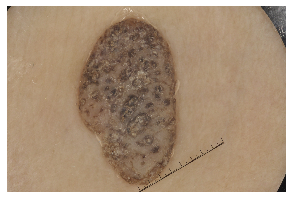

In [10]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))


In [11]:
img.shape

torch.Size([3, 2848, 4288])

In [12]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_segmentation.png'

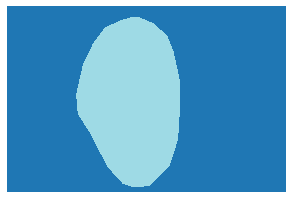

In [13]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:])
src_size,mask

(array([2848, 4288]), ImageSegment (1, 2848, 4288))

In [15]:
mask.data.unique()

tensor([0, 1])

In [16]:
codes = ['Lession', 'Other']

# Load the data

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [18]:
size = src_size//10

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7176MB of GPU RAM free


In [19]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=8)
        .normalize())

In [21]:
bs

4

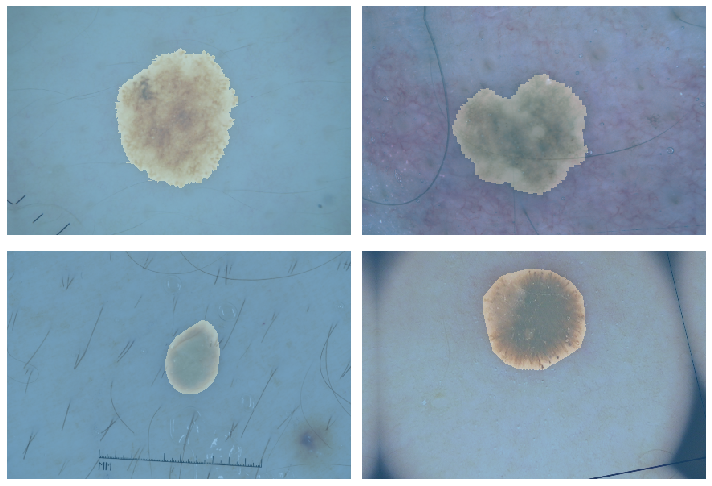

In [22]:
data.show_batch(2, figsize=(10,7))

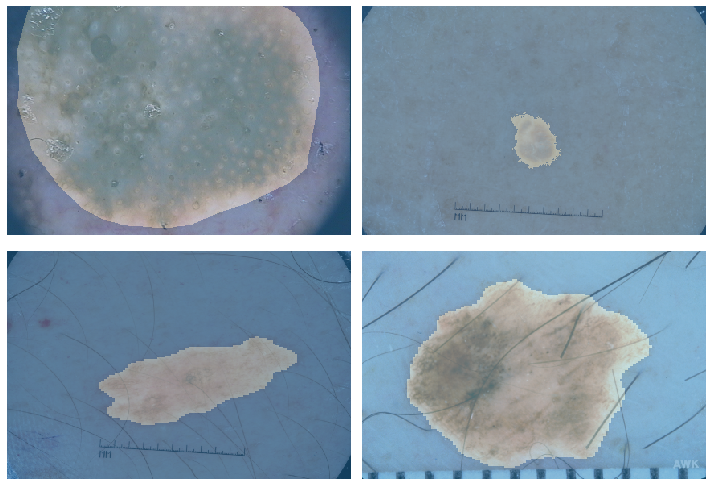

In [23]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

# Model

#### reset memory

In [28]:
torch.cuda.empty_cache()
gc.collect()

this Learner object self-destroyed - it still exists, but no longer usable


In [22]:
# del learn
# del data

In [ ]:
!export CUDA_VISIBLE_DEVICES=1

In [1]:
!nvidia-smi

Mon Nov 18 12:04:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   33C    P8    16W / 250W |      0MiB / 11177MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 39%   65C    P2   112W / 250W |   9149MiB / 11178MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
        

#### define accuracy

In [24]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Other']

def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

In [25]:
metrics=acc_camvid
# metrics=accuracy

In [26]:
wd=1e-2

In [27]:
learn = unet_learner(data, models.resnet34, wd=wd)

In [35]:
learn.path

PosixPath('seg_data/images')

In [33]:
img_f

PosixPath('seg_data/images/ISIC_0012272.jpg')

In [27]:
lr=3e-3

In [28]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,time
0,0.247856,0.191286,03:47
1,0.236057,0.189912,03:39
2,0.203885,0.222294,03:48
3,0.212538,0.175133,03:46
4,0.212421,0.178511,03:38
5,0.179216,0.154013,03:43
6,0.178539,0.148096,03:47
7,0.322328,0.223236,03:38
8,0.167752,0.142183,03:47
9,0.151384,0.139906,03:41


In [ ]:
# model_summary(learn)
learn.show_results??

In [29]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

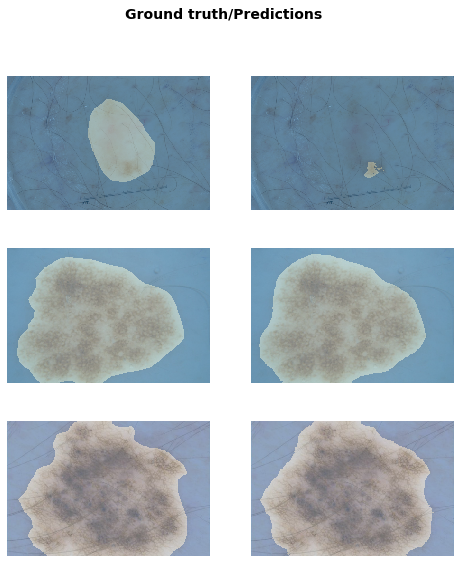

In [30]:
learn.show_results(rows=3, figsize=(8,9))

In [31]:
learn.unfreeze()

In [32]:
lrs = slice(lr/400,lr/4)

In [33]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.139803,0.135366,03:48
1,0.147143,0.135816,03:46
2,0.133000,0.135383,03:44
3,0.131173,0.143745,03:43
4,0.151181,0.137272,03:46
5,0.139439,0.171356,03:49
6,0.142806,0.139735,03:45
7,0.180584,1.112243,03:45
8,0.362289,0.353805,03:45
9,0.378581,0.373986,03:47


In [34]:
learn.save('stage-2');